In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def load_and_split_images(folder, split_point, color_mode=cv2.IMREAD_COLOR):
    images_first_part = []
    images_second_part = []

    # Fonction pour extraire le numéro du nom du fichier
    def extract_number(filename):
        return int(''.join(filter(str.isdigit, filename)))

    # Tri des fichiers par ordre numérique en extrayant le numéro du nom de fichier
    sorted_filenames = sorted(os.listdir(folder), key=extract_number)

    for filename in sorted_filenames:
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".png"):
            img = cv2.imread(img_path, color_mode)
            if img is not None:
                number = extract_number(filename)
                if number <= split_point:
                    images_first_part.append(img)
                else:
                    images_second_part.append(img)
            else:
                print(f"Failed to load image at {img_path}")
    return images_first_part, images_second_part


In [5]:
def load_and_split_images(folder, split_point, color_mode=cv2.IMREAD_COLOR):
    images_first_part = []
    images_second_part = []
    for filename in sorted(os.listdir(folder)):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".png"):
            img = cv2.imread(img_path, color_mode)
            if img is not None:
                number = int(filename.split('.')[0].replace('ref', '').replace('scene', ''))
                if number <= split_point:
                    images_first_part.append(img)
                else:
                    images_second_part.append(img)
            else:
                print(f"Failed to load image at {img_path}")
    return images_first_part, images_second_part

In [6]:
def apply_median_filter(images, kernel_size=5):
    filtered_images = []
    for img in images:
        filtered_img = cv2.medianBlur(img, kernel_size)
        filtered_images.append(cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY))  # Convert to grayscale
    return filtered_images

In [7]:
def angle_between_vectors(v1, v2):
    """Calculate the angle in degrees between vectors 'v1' and 'v2'"""
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0)
    return np.degrees(np.arccos(dot_product))

In [8]:
def detect_and_mask_products(scene_image, model_images):
    sift = cv2.SIFT_create()
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    detections = []
    masked_image = scene_image.copy()
    scene_height, scene_width = scene_image.shape[:2]

    while True:
        scene_keypoints, scene_descriptors = sift.detectAndCompute(masked_image, None)
        max_matches = 0
        best_match = None
        best_model_keypoints = None
        best_homography = None

        for model_idx, model in enumerate(model_images):
            model_keypoints, model_descriptors = sift.detectAndCompute(model, None)
            matches = flann.knnMatch(model_descriptors, scene_descriptors, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

            if len(good_matches) > max_matches:
                max_matches = len(good_matches)
                best_match = model_idx
                best_model_keypoints = model_keypoints

                if len(good_matches) > 10:
                    src_pts = np.float32([model_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    best_homography = homography

        if max_matches < 25:
            break  # Stop if new matches are significantly lower than previous or below the fixed threshold

        if best_homography is not None:
            # Calculate coordinates of model in scene and mask it
            h, w = model_images[best_match].shape[:2]

            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, best_homography)


            # Calculate angles between consecutive corners
            angles = []
            num_corners = len(dst)
            for i in range(num_corners):
                v1 = dst[i][0] - dst[i - 1][0]
                v2 = dst[(i + 1) % num_corners][0] - dst[i][0]
                angle = angle_between_vectors(v1, v2)
                angles.append(angle)

            print(angles)
            print(max_matches)

            if any(60 > angle or angle > 120 for angle in angles):
              break
            # Skip detection if angles are not close to 90 degrees
            if not all(85 <= angle <= 95 for angle in angles):
                # Mask the detected area for processing but don't add to detections
                cv2.fillConvexPoly(masked_image, dst.astype(int), 0)
                continue

            position = tuple(np.int32(dst[0, 0]))
            width = int(np.linalg.norm(dst[0][0] - dst[1][0]))
            height = int(np.linalg.norm(dst[0][0] - dst[3][0]))

            detection_details = (best_match, max_matches, position, width, height, dst)
            detections.append(detection_details)

            # Mask the detected area
            cv2.fillConvexPoly(masked_image, dst.astype(int), 0)

    return masked_image, detections

In [9]:
def draw_detections_on_image(image, detections, model_images):
    for detection in detections:
        best_match, max_matches, position, width, height, dst = detection
        color = (0, 255, 0)  # Green color for the rectangle
        cv2.polylines(image, [np.int32(dst)], True, color, 3)
        label = f'Product {best_match+1}'
        cv2.putText(image, label, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    return image

[90.10383471369343, 90.06261262338782, 89.87953486433858, 89.95401778752955]
682
[89.86326702025221, 90.01738264494135, 90.00848020515643, 90.11087012771705]
540
Product 1 {match: 682, position: (10, 13), width: 1049px, height: 802px}
Product 2 {match: 540, position: (847, 10), width: 1047px, height: 801px}


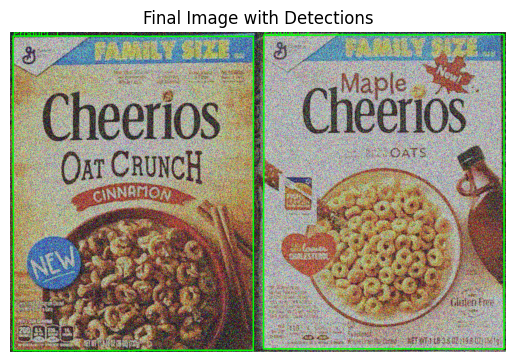

[89.99983076605506, 89.95760547886078, 90.01175595459574, 90.03080779985454]
318
[90.06798986672908, 90.02515078170906, 90.00970684694913, 89.89715250371147]
305
[89.98139208976421, 89.84439644008413, 90.23466290404244, 89.93954857911207]
257
Product 5 {match: 318, position: (1247, 28), width: 842px, height: 560px}
Product 3 {match: 305, position: (3, 22), width: 941px, height: 603px}
Product 4 {match: 257, position: (611, 9), width: 948px, height: 632px}


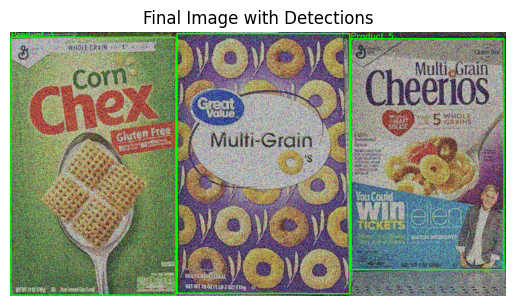

[90.07329879538133, 90.31461898400639, 89.4103659350985, 90.20171631341938]
156
[90.22529295626877, 90.14046935762074, 89.55687857578215, 90.07735909955899]
135
[89.85299234317664, 89.52977290923597, 90.75527932597521, 89.86195534001607]
90
Product 8 {match: 156, position: (1167, 8), width: 778px, height: 558px}
Product 6 {match: 135, position: (-3, 122), width: 671px, height: 602px}
Product 7 {match: 90, position: (618, 136), width: 648px, height: 542px}


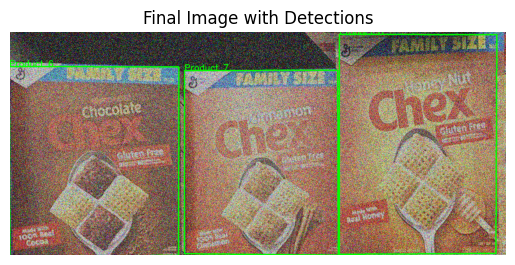

[89.37550290563271, 90.0097426779286, 90.15981798936335, 90.45493636014587]
216
[90.11750242799855, 90.37672681404409, 89.86823859786328, 89.63753219624387]
70
[89.07803611329551, 89.68791606794386, 90.54638504843659, 90.68766287940471]
52
[88.44603526517953, 90.39927634700491, 91.27361713357048, 89.88107119334697]
33
[88.75836973111991, 90.63614183082593, 90.2640916668015, 90.34139683284685]
28
[70.96889975444196, 74.32108006117214, 128.00255025995213, 86.7074696067636]
25
Product 1 {match: 216, position: (695, 663), width: 506px, height: 374px}
Product 9 {match: 70, position: (10, 711), width: 463px, height: 326px}
Product 8 {match: 52, position: (176, 16), width: 483px, height: 347px}
Product 10 {match: 33, position: (807, 97), width: 400px, height: 263px}
Product 7 {match: 28, position: (-169, 96), width: 404px, height: 340px}


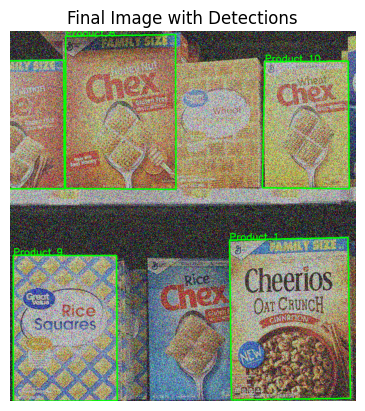

[89.67864762643006, 89.30245599641006, 90.8332038559409, 90.1856924112375]
176
[88.58853461328953, 89.33900199837939, 90.11143343262059, 91.96103006116851]
81
[125.50723678314006, 106.2184241136257, 163.22684242622964, 143.93800663790202]
61
Product 11 {match: 176, position: (186, 476), width: 550px, height: 366px}
Product 12 {match: 81, position: (498, 418), width: 640px, height: 436px}


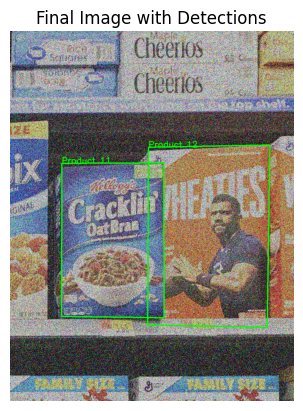

In [ ]:
# Setup paths
scenes_folder = '/content/dataset/scenes'
models_folder = '/content/dataset/models'

# Load and separate images
model_images_first_part, _ = load_and_split_images(models_folder, 14)
scene_images_first_part, _ = load_and_split_images(scenes_folder, 5, cv2.IMREAD_COLOR)

# Apply median filter and convert to grayscale
filtered_scene_images = apply_median_filter(scene_images_first_part, kernel_size=5)

# Detect products and mask them iteratively
for scene_image, original_image in zip(filtered_scene_images, scene_images_first_part):
    result_image, product_detections = detect_and_mask_products(scene_image, model_images_first_part)
    final_image = draw_detections_on_image(original_image, product_detections, model_images_first_part)
    for detection in product_detections:
        best_match, max_matches, position, width, height, dst = detection
        print(f"Product {best_match + 1} {{match: {max_matches}, position: {position}, width: {width}px, height: {height}px}}")

    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))  # Display the final image with detections
    plt.title('Final Image with Detections')
    plt.axis('off')
    plt.show()

In [14]:
def detect_and_mask_products_taskb(scene_image, model_images):
    sift = cv2.SIFT_create()
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    detections = []
    masked_image = scene_image.copy()
    scene_height, scene_width = scene_image.shape[:2]

    while True:
        scene_keypoints, scene_descriptors = sift.detectAndCompute(masked_image, None)
        max_matches = 0
        best_match = None
        best_model_keypoints = None
        best_homography = None

        for model_idx, model in enumerate(model_images):
            model_keypoints, model_descriptors = sift.detectAndCompute(model, None)
            matches = flann.knnMatch(model_descriptors, scene_descriptors, k=2)
            good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]  # Lowered distance

            if len(good_matches) > max_matches:
                max_matches = len(good_matches)
                best_match = model_idx
                best_model_keypoints = model_keypoints

                if len(good_matches) > 15:
                    src_pts = np.float32([model_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    best_homography = homography

        if max_matches < 10:
            break  # Stop if new matches are significantly lower than previous or below the fixed threshold

        if best_homography is not None:
            # Calculate coordinates of model in scene and mask it
            h, w = model_images[best_match].shape[:2]

            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, best_homography)


            # Calculate angles between consecutive corners
            angles = []
            num_corners = len(dst)
            for i in range(num_corners):
                v1 = dst[i][0] - dst[i - 1][0]
                v2 = dst[(i + 1) % num_corners][0] - dst[i][0]
                angle = angle_between_vectors(v1, v2)
                angles.append(angle)

            print(angles)
            print(max_matches)

            if any(60 > angle or angle > 120 for angle in angles):
              break


            # # Skip detection if detected area is less than half of the reference area or less than half of the last detected area or angles are not close to 90 degrees
            # if not all(80 <= angle <= 100 for angle in angles):
            #     # Mask the detected area for processing but don't add to detections
            #     cv2.fillConvexPoly(masked_image, dst.astype(int), 0)
            #     continue

            position = tuple(np.int32(dst[0, 0]))
            width = int(np.linalg.norm(dst[0][0] - dst[1][0]))
            height = int(np.linalg.norm(dst[0][0] - dst[3][0]))

            detection_details = (best_match, max_matches, position, width, height, dst)
            detections.append(detection_details)

            # Mask the detected area
            cv2.fillConvexPoly(masked_image, dst.astype(int), 0)

    return masked_image, detections

def draw_detections_on_imageb(image, detections, model_images):
    for detection in detections:
        best_match, max_matches, position, width, height, dst = detection
        color = (0, 255, 0)  # Green color for the rectangle
        cv2.polylines(image, [np.int32(dst)], True, color, 3)
        label = f'Product {best_match+15}'
        cv2.putText(image, label, position, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    return image


[91.58520045127885, 90.57319604810606, 89.22192735927077, 88.61967617771252]
48
[89.58542889951576, 85.3485335457033, 95.09995304542807, 89.96608409338603]
50
[89.38276990650894, 89.59146291366261, 90.40384230720258, 90.62192494910276]
42
[89.77868155032398, 88.37973511379182, 91.29453578577193, 90.54704755358546]
39
[177.37437710158568, 176.32880144100292, 70.09666667684155, 69.05102306143776]
20
Product 22 {match: 48, position: (1136, 183), width: 703px, height: 249px}
Product 21 {match: 50, position: (862, 190), width: 691px, height: 245px}
Product 22 {match: 42, position: (1402, 190), width: 690px, height: 250px}
Product 21 {match: 39, position: (587, 188), width: 685px, height: 246px}


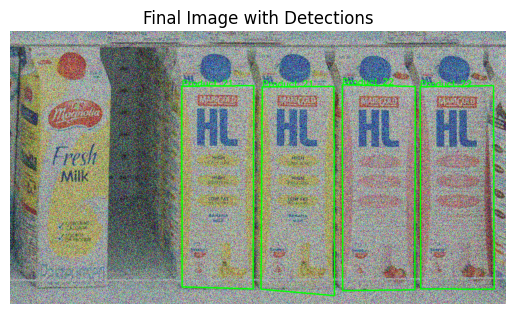

[89.8460001796908, 89.84752651898579, 90.41070316543345, 89.89577016854992]
65
[90.01686019214242, 90.37579868871676, 89.6469861093952, 89.96035499089237]
54
[90.3646637004216, 88.45141611796363, 91.76782906448379, 89.41609105442596]
47
[91.87404883171631, 92.43368567824137, 87.37633643262244, 88.31592913225079]
47
[89.76404127007758, 90.96593194038174, 88.59336822027723, 90.6766586113466]
45
[90.98302365244325, 90.24715599078178, 89.45530203140143, 89.31451834869696]
37
[89.48284589867048, 89.88787047372871, 90.70996227763081, 89.91932135197582]
32
[4.695859994439935, 178.9040701726775, 7.888766524095051, 177.9028614880026]
16
Product 23 {match: 65, position: (267, 116), width: 489px, height: 180px}
Product 17 {match: 54, position: (75, 121), width: 480px, height: 182px}
Product 24 {match: 47, position: (462, 127), width: 479px, height: 185px}
Product 25 {match: 47, position: (847, 128), width: 484px, height: 190px}
Product 25 {match: 45, position: (1247, 136), width: 480px, height: 1

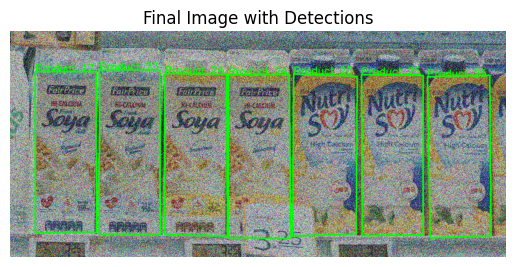

[89.45112411325907, 89.40687637632988, 90.89751256914303, 90.24448712316067]
46
[88.31990452128706, 89.1471379589398, 91.49894649756041, 91.03401123081886]
41
[95.48272180032161, 93.12856830048219, 86.6584346347156, 84.7302747526448]
24
[105.31706220787447, 102.38493430163241, 71.26285427038694, 81.03514997971752]
24
Product 26 {match: 46, position: (295, 101), width: 587px, height: 227px}
Product 26 {match: 41, position: (31, 95), width: 581px, height: 226px}
Product 26 {match: 24, position: (840, 81), width: 607px, height: 233px}
Product 18 {match: 24, position: (566, 0), width: 688px, height: 284px}


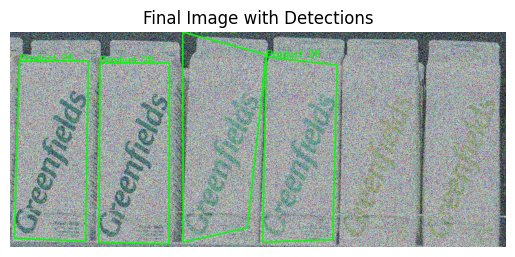

[89.87040828246546, 89.38947038650925, 90.415023799143, 90.32509753794454]
64
[88.78077215431374, 89.49669022724083, 90.94419483160699, 90.77834288501502]
58
[89.96492089328322, 82.70169269524487, 97.5837398380366, 89.74964673018141]
35
[75.60424670311876, 39.19784981048395, 162.64215440137065, 82.55575572089012]
22
Product 15 {match: 64, position: (418, 167), width: 901px, height: 327px}
Product 15 {match: 58, position: (24, 169), width: 902px, height: 334px}
Product 15 {match: 35, position: (770, 178), width: 883px, height: 326px}


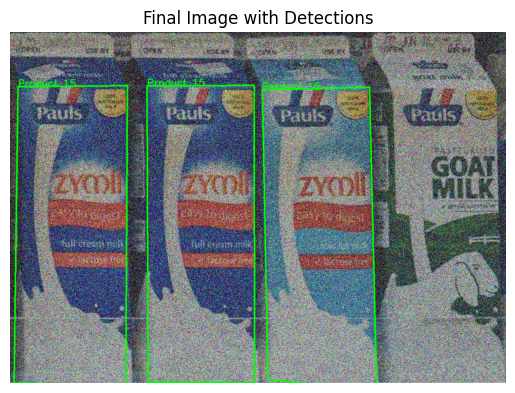

[89.4729386714595, 88.57347561791858, 91.44379844009423, 90.50978728639838]
179
[89.69884073844817, 90.18649757739372, 89.85579271643931, 90.25886894561597]
134
[175.6731931899711, 177.34221938520852, 173.39793656535284, 175.06695671111672]
21
Product 16 {match: 179, position: (916, 166), width: 595px, height: 215px}
Product 16 {match: 134, position: (687, 162), width: 600px, height: 216px}


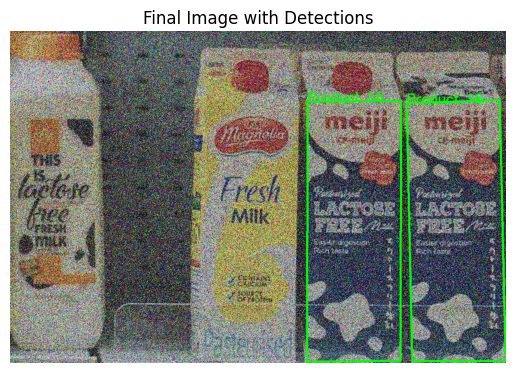

[89.3081809161348, 89.95199885897097, 90.02849227536927, 90.7113279402604]
145
[90.15948973880242, 90.2989746649555, 89.72374248374987, 89.81779308427635]
153
[89.93016585412896, 89.87772021774273, 90.08115326660354, 90.11096066791383]
95
[94.57208725572012, 90.74351854851278, 88.83377139317723, 85.85062240075536]
43
Product 17 {match: 145, position: (485, 143), width: 850px, height: 326px}
Product 23 {match: 153, position: (826, 132), width: 870px, height: 322px}
Product 24 {match: 95, position: (1175, 153), width: 851px, height: 326px}
Product 27 {match: 43, position: (127, 156), width: 783px, height: 334px}


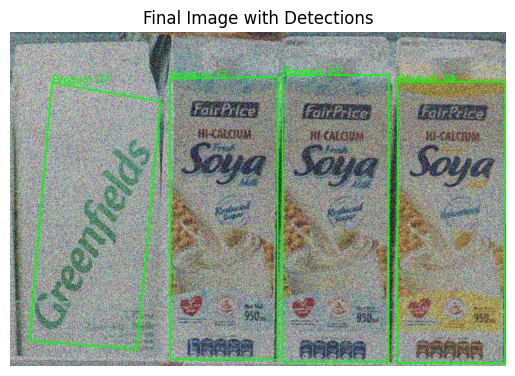

[92.97732232285746, 91.92353767553223, 86.61448499087058, 88.48465462817262]
51
[89.72192971432587, 89.66422739253052, 90.359879804333, 90.25396308643465]
36
[91.93180624339882, 93.5203574608708, 85.42389318238877, 89.12394309132752]
28
[89.40643479159401, 85.43739412741932, 94.24867677870644, 90.90749452811204]
20
[144.50416452206517, 142.4146419691997, 158.9500505614588, 85.86883738617327]
17
Product 19 {match: 51, position: (728, 85), width: 574px, height: 232px}
Product 19 {match: 36, position: (505, 98), width: 553px, height: 223px}
Product 20 {match: 28, position: (983, 94), width: 560px, height: 234px}
Product 20 {match: 20, position: (1247, 100), width: 541px, height: 228px}


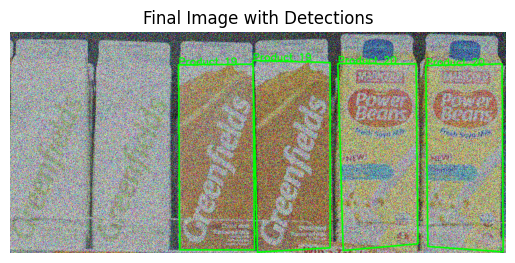

In [15]:
# Load and separate images
# Setup paths
scenes_folder = '/content/dataset/scenes'
models_folder = '/content/dataset/models'



model_images_first_part, model_images_second_part = load_and_split_images(models_folder, 14)
scene_images_first_part, scene_images_second_part = load_and_split_images(scenes_folder, 5, cv2.IMREAD_COLOR)

# Apply median filter and convert to grayscale
filtered_scene_images = apply_median_filter(scene_images_second_part, kernel_size=5)

# Detect products and mask them iteratively
for scene_image, original_image in zip(filtered_scene_images, scene_images_second_part):
    result_image, product_detections = detect_and_mask_products_taskb(scene_image,model_images_second_part)
    final_image = draw_detections_on_imageb(original_image, product_detections, model_images_second_part)
    for detection in product_detections:
        best_match, max_matches, position, width, height, dst = detection
        print(f"Product {best_match + 15} {{match: {max_matches}, position: {position}, width: {width}px, height: {height}px}}")

    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))  # Display the final image with detections
    plt.title('Final Image with Detections')
    plt.axis('off')
    plt.show()


To see a specific image of the database

In [ ]:
# import matplotlib.pyplot as plt
# scenes_folder = '/content/dataset/scenes'
# def apply_median_filter(images, kernel_size=9):
#     filtered_images = []
#     for img in images:
#         filtered_img = cv2.medianBlur(img, kernel_size)
#         filtered_images.append(filtered_img)
#     return filtered_images

# # Load and split images from the scenes folder
# scenes_folder = '/content/dataset/scenes'
# scene_images_first_part, _ = load_and_split_images(scenes_folder, 5, cv2.IMREAD_COLOR)

# # Apply the median filter to the loaded images
# filtered_scene_images = apply_median_filter(scene_images_first_part, kernel_size=5)

# # Convert a filtered image to grayscale and display it
# gray_image = cv2.cvtColor(filtered_scene_images[4], cv2.COLOR_BGR2RGB)
# plt.imshow(gray_image)  # Ensure the image is shown in grayscale
# plt.axis('off')  # Hide axes for clarity
# plt.show()

In [ ]:
# plt.imshow(model_images_first_part[5], cmap='gray')